In [ ]:
import os
import argparse
import time
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
#from uci_datasets import Dataset

device = torch.device('cuda:0')

!pip install torchdiffeq

adjoint = False

if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/CSC2516_Project'
#data_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets'

traintest = pd.read_csv(f'{data_dir}/cylinder2d.csv')
traintest_tensor = torch.unflatten(torch.tensor(traintest.to_numpy()), 0, (1501, 80, 640))
traintest_img = torch.permute(traintest_tensor[:, :, :160, :].to(torch.float32), (0, 3, 1, 2))

state_shape = traintest_img.shape[1:]

train_size = int((9./15.)*traintest_img.size(0))
train_idx = np.arange(0, train_size)#random.sample(range(traintest_img.size(0)), train_size)
train_img = traintest_img[train_idx]

train_set = TensorDataset(train_img, train_img)

test_idx = np.setdiff1d(range(traintest_img.size(0)), train_idx)
test_img = traintest_img[test_idx]

test_set = TensorDataset(test_img, test_img)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(train_size)

900


In [ ]:
batch_size = 50
batch_time_max = 25

def get_batch(z_train):
    batch_time = batch_time_max#random.randint(10, batch_time_max)
    s = torch.from_numpy(np.random.choice(np.arange(train_size - batch_time, dtype=np.int64),batch_size, replace=False))
    batch_z0 = z_train[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_z = torch.stack([z_train[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_z0.to(device), batch_t.to(device), batch_z.to(device)

In [ ]:
#NODE constructor with number of inputs and outputs, number of hidden layer nodes as inputs, add tanh() layers between linear ones
class CascadeLinear(nn.Module):
    """ Linear layer in which only some input nodes are connected to all output nodes """
    def __init__(self, size_in, size_out, fc_frac):
        super().__init__()
        #self.size_in, self.size_out = size_in, size_out
        weight = torch.Tensor(size_out, size_in)
        self.W = nn.Parameter(weight)  # nn.Parameter is a Tensor that's a module parameter.
        bias = torch.Tensor(size_out)
        self.b = nn.Parameter(bias)

        self.mask = torch.zeros((size_out, size_in)).bool().to(device)

        fc_in = int(fc_frac*size_in)
        fc_out = int(fc_frac*size_out)

        self.mask[:fc_out, :fc_in] = True

        for i in range(fc_out, size_out):
            fc_frac_i = (1 - fc_frac)*(i + 1 - fc_out)/(size_out - fc_out) + fc_frac
            fc_in = int(np.ceil(fc_frac_i*size_in))
            self.mask[i, :fc_in] = True

        # initialize weights and biases
        nn.init.xavier_uniform_(self.W) # weight init
        nn.init.zeros_(self.b)  # bias init

    def mask_tensor(self, input, mask):
        masked_tensor = torch.zeros(input.size()).to(device)
        masked_tensor[mask] = input[mask]
        return masked_tensor
    
    def forward(self, x):
        Wmasked = self.mask_tensor(self.W, self.mask)
        Wx = torch.matmul(x, Wmasked.t())
        return torch.add(Wx, self.b)  # w times x + b

class NODE(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()

        self.state_dim = state_dim
        activ = nn.Tanh()
        fc_frac = 4/state_dim

        self.net = nn.Sequential(CascadeLinear(state_dim, hidden_dim, fc_frac),
                                activ,
                                CascadeLinear(hidden_dim, hidden_dim, fc_frac),
                                activ,
                                CascadeLinear(hidden_dim, state_dim, fc_frac)
                                )

        '''
        self.net1 = nn.Sequential(nn.Linear(state_dim-1, hidden_dim),
                                activ,
                                nn.Linear(hidden_dim, hidden_dim),
                                activ,
                                nn.Linear(hidden_dim, state_dim-1)
                                )

        self.net2 = nn.Sequential(nn.Linear(state_dim, hidden_dim),
                                activ,
                                nn.Linear(hidden_dim, hidden_dim),
                                activ,
                                nn.Linear(hidden_dim, 1)
                                )
        
        for layer in self.net1.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
        
        for layer in self.net2.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
                '''
        
    def odefunc(self, t, z):
        zdot = self.net(z)
        #if z.dim() == 1:
        #    zdot = torch.cat((self.net1(z[:-1]), self.net2(z)), dim=0)
        #elif z.dim() == 2:
        #    zdot = torch.cat((self.net1(z[:,:-1]), self.net2(z)), dim=1)
        return zdot

    def forward(self, z0, t):
        return odeint(self.odefunc, z0, t)

In [ ]:
def form_pod_basis(train_img, dim):
    img_flat = torch.flatten(train_img, start_dim = 1)
    U,S,VT = torch.linalg.svd(img_flat.transpose(0, 1), full_matrices=False)
    img_mean = torch.mean(img_flat, dim=0)
    return U[:,:dim], img_mean

def lin_encode(img, modes, mean):
    img_flat = torch.flatten(img, start_dim = 1) - mean
    z = torch.tensordot(img_flat, modes, dims=1)
    return z

def lin_decode(z, modes, mean):
    img_flat = torch.tensordot(z, modes.transpose(0, 1), dims=1) + mean
    img = img_flat.reshape(img_flat.shape[0], *state_shape)
    return img

In [ ]:
def visualize(true_y, pred_y, t, ax_traj):
    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0], 'g-')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0], 'b--')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    
    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.1)

In [ ]:
encdim = 6
hiddim = 150
lr = 3e-2
num_epochs = 300
reg_gain = 0

dt = 15/(traintest_img.size(0) - 1)
n_t = train_size
T_f = dt*n_t
t = torch.linspace(0., T_f, n_t).to(device)

# generalize so user enters training set and you extract N, need arch of NODE - String(#attributes,#output,#number of nodes in hidden layer), #timesteps

modes, mean = form_pod_basis(train_img, encdim)
z_train = lin_encode(train_img, modes, mean).to(device)
z_test = lin_encode(test_img, modes, mean).to(device)

mynode = NODE(encdim, hiddim).to(device)

# set optimizer
optimizer = torch.optim.Adam(mynode.parameters(), lr=lr)
lastloss = np.nan
pc = 0

# store train and val loss over epochs for plotting
train_loss_epoch = []

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# optimize for num_epochs
for i in range(num_epochs):
    sum_train_loss = 0
    sum_val_loss = 0

    batch_z0, batch_t, batch_z = get_batch(z_train)

    # training set
    z_pred = mynode(batch_z0, batch_t)
    visualize(batch_z, z_pred.detach(), batch_t, ax)
    sample_loss = torch.mean(torch.abs(z_pred - batch_z))# + reg_gain*torch.mean(torch.abs(z_pred[:,:,-1]))
    train_loss_epoch.append(sample_loss.detach().item())

    # perform optimization with respect to sample loss
    optimizer.zero_grad()
    sample_loss.backward()
    optimizer.step()

    print(f'Epoch: {i}, Loss: {sample_loss.item()}')

Epoch: 299, Loss: 0.13746702671051025


In [ ]:
print(z_train.shape)

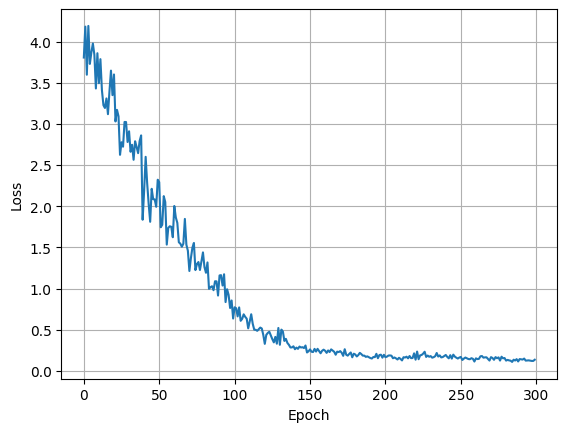

AttributeError: ignored

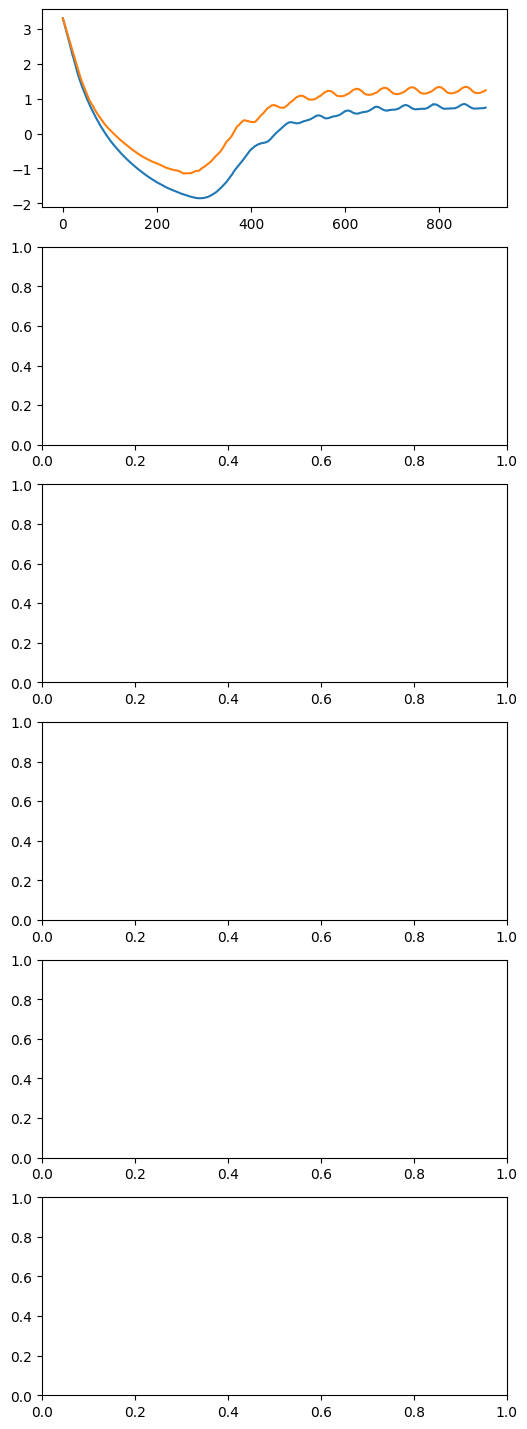

In [ ]:
plt.figure()
plt.plot(np.arange(len(train_loss_epoch)), train_loss_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()
z_pred_train = mynode(z_train[0], t)


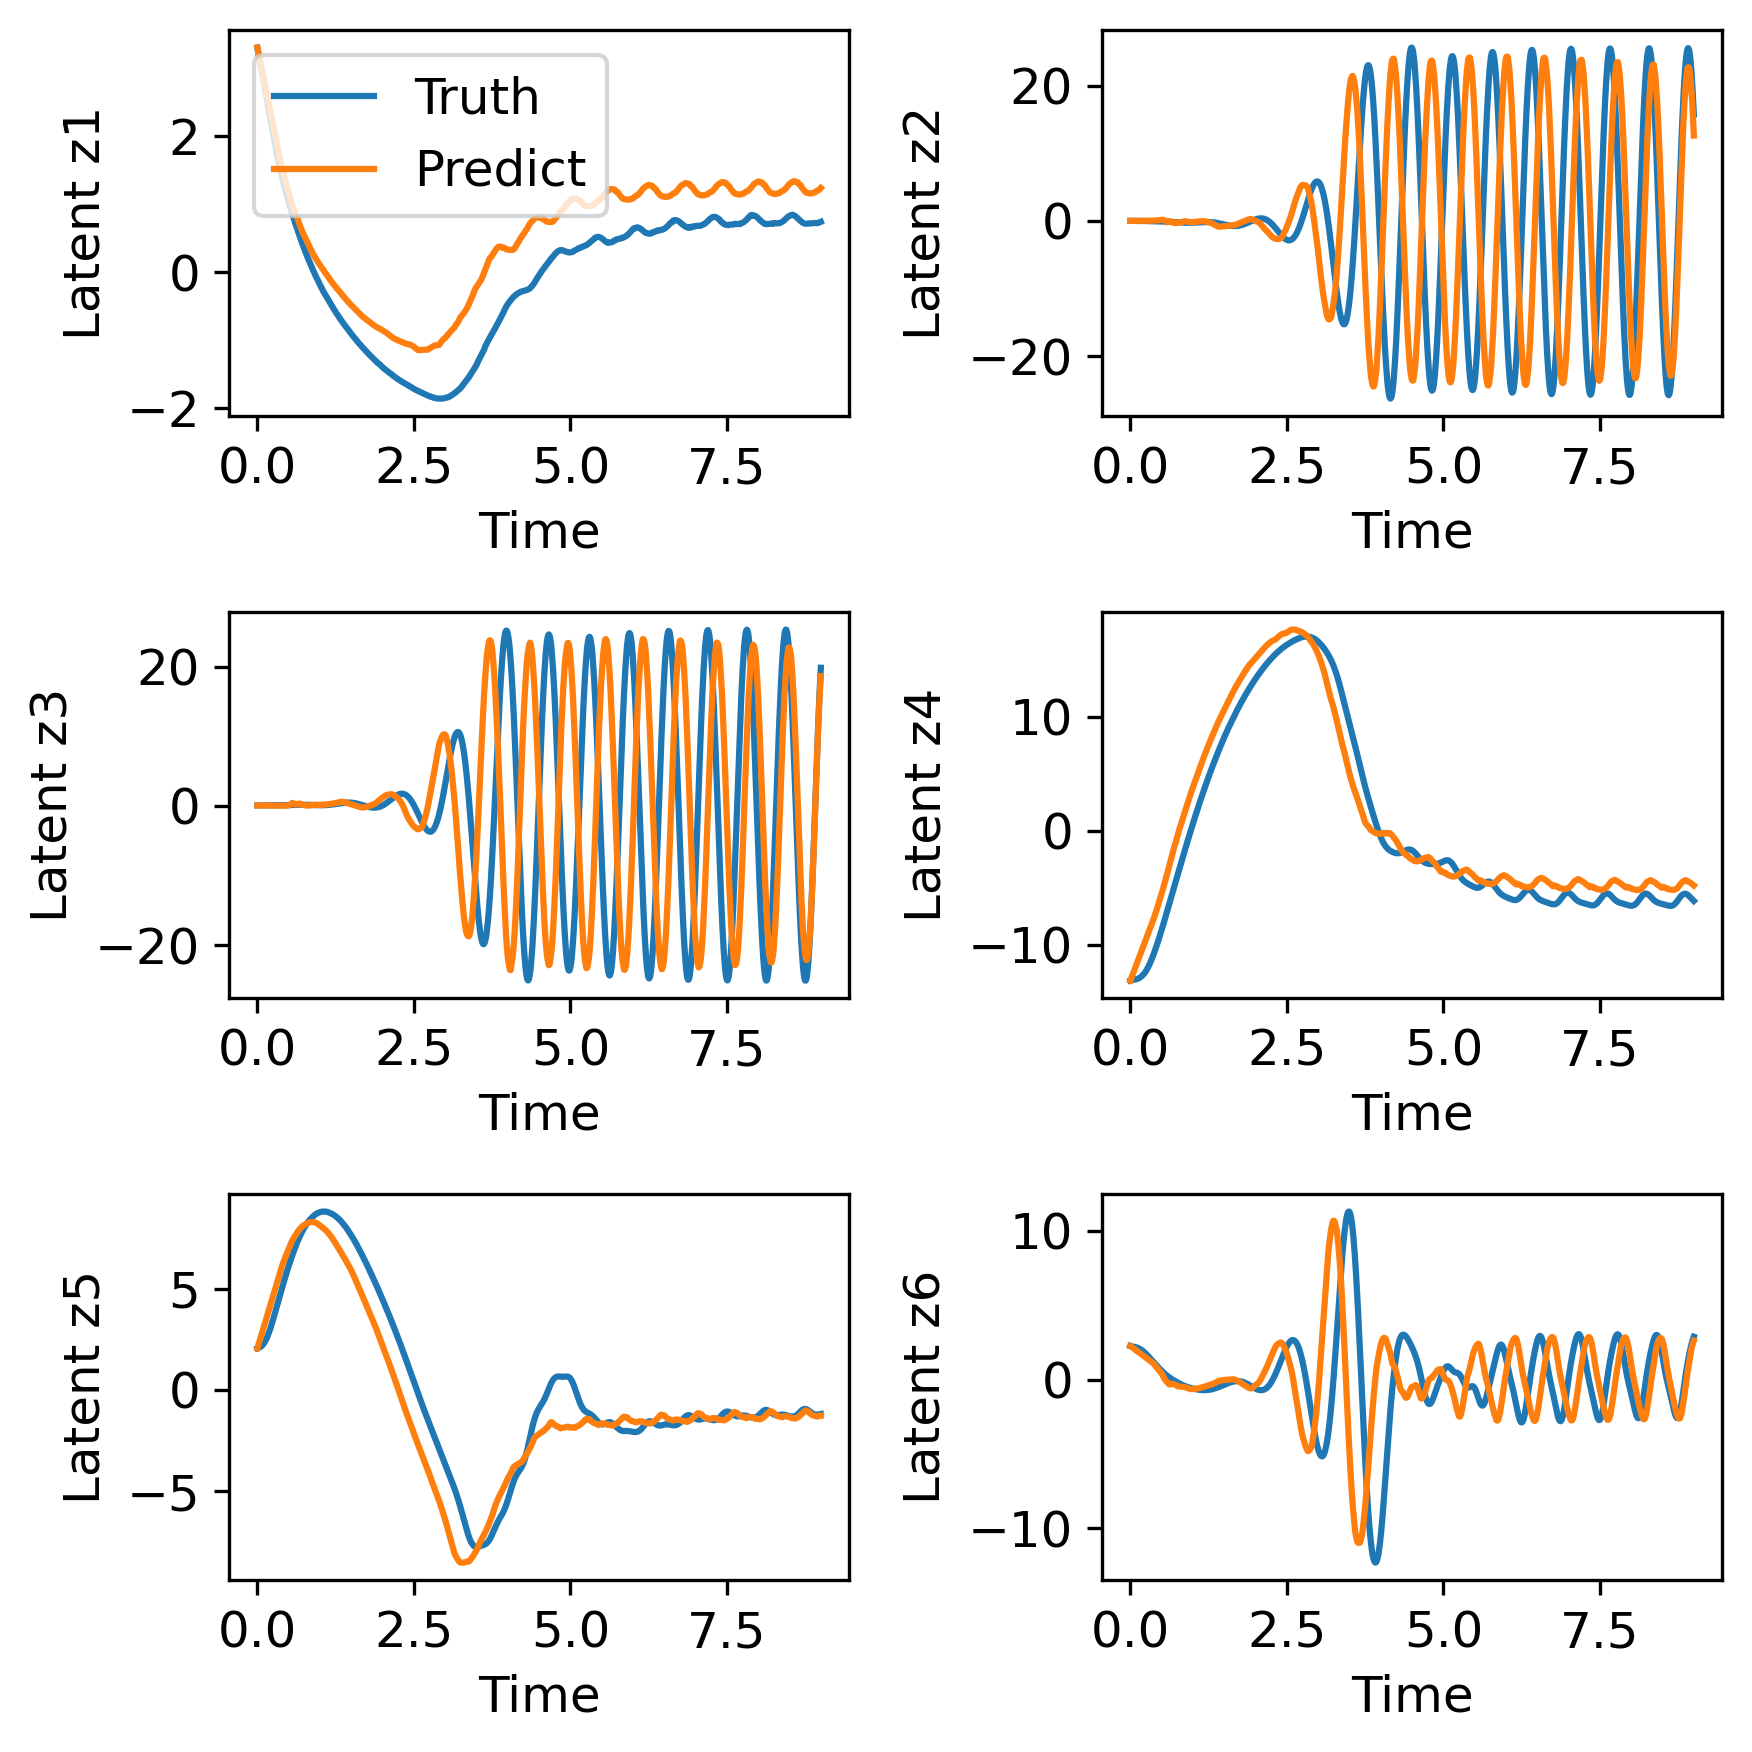

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
f, ax = plt.subplots(encdim//2, 2, figsize=(6, encdim*1), dpi=300)

for i in range(encdim):
    ax[i // 2, i % 2].plot(t.cpu(), z_train[:,i].cpu(), label = "Truth")
    ax[i // 2, i % 2].plot(t.cpu(), z_pred_train[:,i].cpu().detach().numpy(), label = "Predict")
    if i == 0:
        ax[i // 2, i % 2].legend()   

i_z = 0
for ax_i in ax.flat:
    i_z += 1
    ax_i.set(xlabel='Time', ylabel=f'Latent z{i_z}')
plt.tight_layout()

plt.show()

In [ ]:
test_size = traintest_img.size(0) - train_size
t_test = torch.linspace(T_f, T_f + dt*test_size, test_size).to(device)

z_pred_test = mynode(z_test[0], t_test)


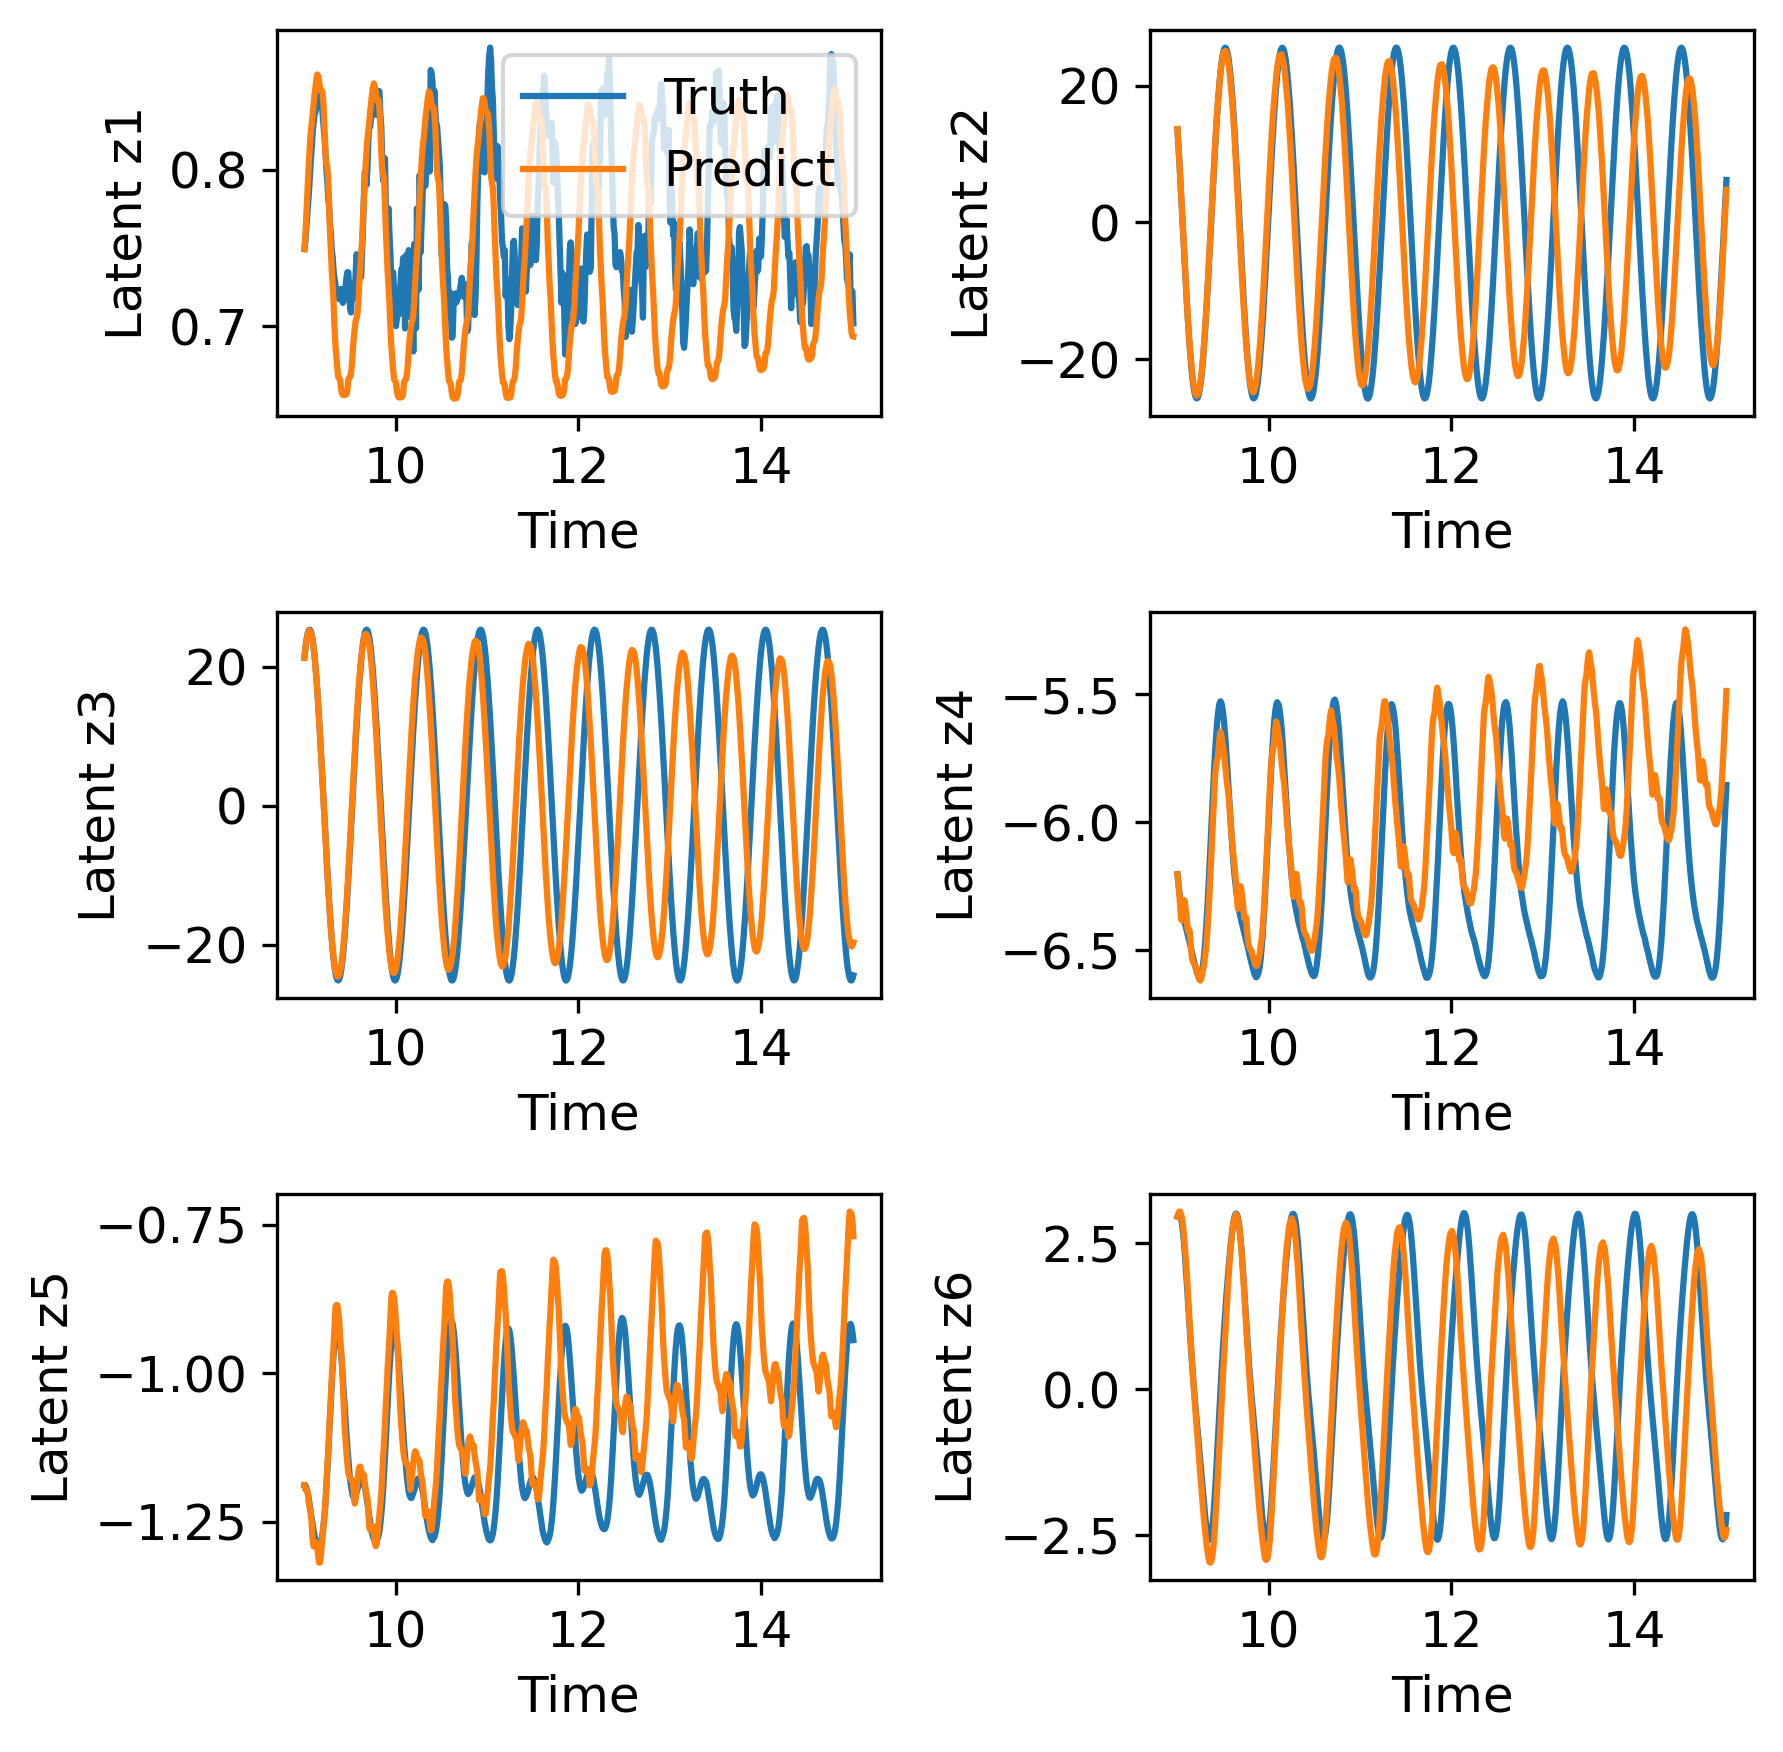

In [ ]:
f, ax = plt.subplots(encdim//2, 2, figsize=(6, encdim*1), dpi=300)

for i in range(encdim):
    ax[i // 2, i % 2].plot(t_test.cpu(), z_test[:,i].cpu(), label = "Truth")
    ax[i // 2, i % 2].plot(t_test.cpu(), z_pred_test[:,i].cpu().detach().numpy(), label = "Predict")
    if i == 0:
        ax[i // 2, i % 2].legend()   

i_z = 0
for ax_i in ax.flat:
    i_z += 1
    ax_i.set(xlabel='Time', ylabel=f'Latent z{i_z}')
plt.tight_layout()

plt.show()